<a href="https://colab.research.google.com/github/kaspgreta/DeepLearning/blob/main/Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openimages

     |████████████████████████████████| 51kB 2.3MB/s 
     |████████████████████████████████| 133kB 6.2MB/s 
     |████████████████████████████████| 296kB 6.2MB/s 
     |████████████████████████████████| 144.2MB 77kB/s 
     |████████████████████████████████| 81kB 7.1MB/s 
     |████████████████████████████████| 7.4MB 36.1MB/s 
ERROR: botocore 1.20.57 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


**Importing packages**

In [40]:
from openimages.download import download_dataset
import os
import tensorflow as tf
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import GlobalAveragePooling2D
import keras.layers
from keras.models import Model
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.metrics import categorical_crossentropy
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from IPython.display import Image
import cv2
import math
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from PIL import Image
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import f1_score

**Data preparation**

In [7]:
data_destination_directory = "data"
number_of_samples = 4000
classes = ["Human body", "Horse", "Knife"]

In [8]:
#creating directory
if not os.path.exists(data_destination_directory):
    os.makedirs(data_destination_directory)

In [9]:
#downloading data
download_dataset(data_destination_directory, classes, limit = number_of_samples)

2021-04-26  15:56:31 INFO NumExpr defaulting to 2 threads.
2021-04-26  15:56:34 INFO Downloading 4000 train images for class 'human body'
100%|██████████| 4000/4000 [00:56<00:00, 71.13it/s]
2021-04-26  15:57:31 INFO Downloading 751 train images for class 'horse'
100%|██████████| 751/751 [00:10<00:00, 70.12it/s]
2021-04-26  15:57:42 INFO Downloading 355 train images for class 'knife'
100%|██████████| 355/355 [00:04<00:00, 73.37it/s]


{'horse': {'images_dir': 'data/horse/images'},
 'human body': {'images_dir': 'data/human body/images'},
 'knife': {'images_dir': 'data/knife/images'}}

**Making dataset**

In [21]:
def get_data(data_dir, img_size, labels):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label+'/images')
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [12]:
def get_class_weights(data):
  labels = []
  for index in range(len(data)):
    labels.append(data[index][1])
  class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(labels),
                                                 labels)
  class_weights = {0: class_weights[0], 1: class_weights[1],2: class_weights[2]}
  return class_weights

In [14]:
def data_set_split(data):
  train_data_set = []
  validating_data_set = []
  test_data_set = []
  for i in range(0,len(data)):
    if i%10 <7:
      train_data_set.append(data[i])
    elif i%10 <9:
      validating_data_set.append(data[i])
    else:
      test_data_set.append(data[i])
      
  train_data_set = shuffle(train_data_set, random_state=0)
  validating_data_set = shuffle(validating_data_set, random_state=0)
  test_data_set = shuffle(test_data_set, random_state=0)

  return train_data_set, validating_data_set, test_data_set

In [15]:
def normalize_data(train_data_set, validating_data_set, test_data_set, img_size):
  x_train = []
  y_train = []
  x_val = []
  y_val = []
  x_test = []
  y_test = []

  def label_to_array(number):
    if number == 0:
      return [1,0,0]
    elif number == 1:
      return [0,1,0]
    elif number == 2:
      return [0,0,1]
    else:
      print("error")

  for feature, label in train_data_set:
    x_train.append(feature)
    y_train.append(label_to_array(label))

  for feature, label in validating_data_set:
    x_val.append(feature)
    y_val.append(label_to_array(label))
    
  for feature, label in test_data_set:
    x_test.append(feature)
    y_test.append(label_to_array(label))

  x_train = np.array(x_train) / 255
  x_val = np.array(x_val) / 255
  x_test = np.array(x_test) / 255

  x_train.reshape(-1, img_size, img_size, 1)
  y_train = np.array(y_train)
  x_val.reshape(-1, img_size, img_size, 1)
  y_val = np.array(y_val)
  x_test.reshape(-1, img_size, img_size, 1)
  y_test = np.array(y_test)

  return x_train, y_train, x_val, y_val, x_test, y_test

In [23]:
def make_data(folder, image_size, labels):
  data = get_data(folder,
                  image_size,
                  labels)
  class_weights = get_class_weights(data)
  train_data_set, validating_data_set, test_data_set = data_set_split(data)
  x_train, y_train, x_val, y_val, x_test, y_test = normalize_data(train_data_set,
                                                                  validating_data_set,
                                                                  test_data_set,
                                                                  image_size)
  return class_weights, x_train, y_train, x_val, y_val, x_test, y_test

In [27]:
class_weights, x_train, y_train, x_val, y_val, x_test, y_test = make_data('./data', 224, ["human body", "horse", "knife"])

**Training model**

In [46]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                      monitor='val_loss',
                      patience=5,
                      mode='min',
                      restore_best_weights=True
                  )

**0.5 MobileNet-160**

In [33]:
class_weights, x_train, y_train, x_val, y_val, x_test, y_test = make_data('./data', 160, ["human body", "horse", "knife"])

In [34]:
model_05_160_base=MobileNet(
                        input_shape = (160,160,3),
                        alpha=0.5,
                        depth_multiplier=1,
                        include_top=False#,
                        #pooling ='avg'
                    )

5578752/5577668 [==============================] - 0s 0us/step


In [36]:
x=model_05_160_base.output
x=GlobalAveragePooling2D()(x)
x=Dense(6, input_dim=3, kernel_initializer='he_uniform', activation='relu')(x)
preds=Dense(3, activation='sigmoid')(x)

In [37]:
model_05_160=Model(inputs=model_05_160_base.input,outputs=preds)

In [47]:
opt = SGD(lr=0.0001)
model_05_160.compile(optimizer = opt, 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy']
             )

history_05_160 = model_05_160.fit(x_train,y_train,
                    epochs = 20,
                    callbacks=[early_stopping],
                    validation_data = (x_val, y_val),
                    class_weight=class_weights
                   )

Epoch 1/20
112/112 [==============================] - 178s 2s/step - loss: 0.2942 - accuracy: 0.8158 - val_loss: 0.4250 - val_accuracy: 0.8049
Epoch 2/20
112/112 [==============================] - 172s 2s/step - loss: 0.3116 - accuracy: 0.8244 - val_loss: 0.4169 - val_accuracy: 0.8275
Epoch 3/20
112/112 [==============================] - 173s 2s/step - loss: 0.2845 - accuracy: 0.8438 - val_loss: 0.4105 - val_accuracy: 0.8343
Epoch 4/20
112/112 [==============================] - 171s 2s/step - loss: 0.2948 - accuracy: 0.8366 - val_loss: 0.4060 - val_accuracy: 0.8412
Epoch 5/20
112/112 [==============================] - 170s 2s/step - loss: 0.2781 - accuracy: 0.8533 - val_loss: 0.4000 - val_accuracy: 0.8441
Epoch 6/20
112/112 [==============================] - 170s 2s/step - loss: 0.2899 - accuracy: 0.8387 - val_loss: 0.3934 - val_accuracy: 0.8490
Epoch 7/20
112/112 [==============================] - 171s 2s/step - loss: 0.2777 - accuracy: 0.8673 - val_loss: 0.3901 - val_accuracy: 0.8500

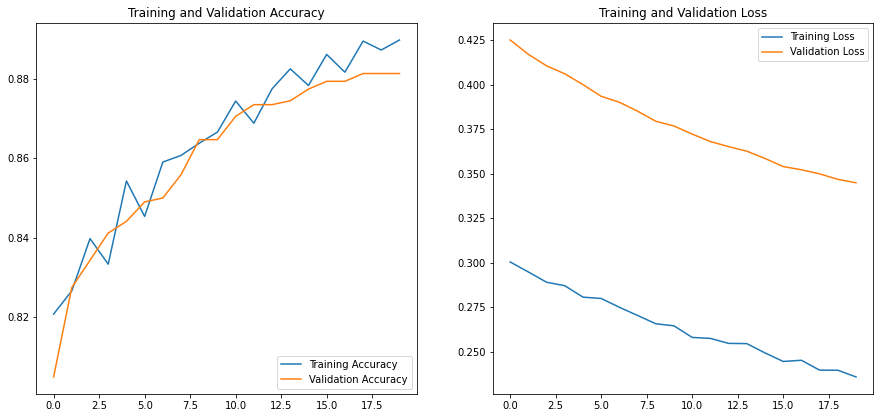

In [48]:
acc = history_05_160.history['accuracy']
val_acc = history_05_160.history['val_accuracy']
loss = history_05_160.history['loss']
val_loss = history_05_160.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [49]:
test_loss, test_acc = model_05_160.evaluate(x_test,  y_test, verbose=2)
print('Test accuracy:', test_acc)

16/16 - 5s - loss: 0.3446 - accuracy: 0.8588
Test accuracy: 0.8588235378265381


In [50]:
predictions_05_160 = model_05_160.predict(x_test)
predictions_05_160 = predictions_05_160.round(0)
print("F1 score macro {}".format(f1_score(y_test, predictions_05_160, average='macro')))
print("F1 score micro {}".format(f1_score(y_test, predictions_05_160, average='micro')))
print("F1 score weighted {}".format(f1_score(y_test, predictions_05_160, average='weighted')))

F1 score macro 0.8168745093122461
F1 score micro 0.7920353982300884
F1 score weighted 0.7875275118779143


**Predictions of random files**

In [53]:
path = os.path.join('./testing')
img_name = 'cat.jpg'
img_arr = cv2.imread(os.path.join(path, img_name))[...,::-1] #convert BGR to RGB format
image = cv2.resize(img_arr, (160, 160)) # Reshaping images to preferred size

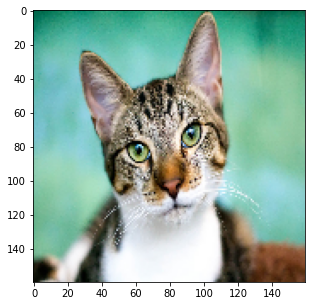

In [54]:
plt.figure(figsize = (5,5))
plt.imshow(image)

In [57]:
image = np.array(image) / 255
image = image.reshape(1, 160, 160, 3)
model_05_160.predict(image).round(5)

array([[0.4574 , 0.17624, 0.15578]], dtype=float32)